### Приложение E
#### МЕТОДИКА РАСЧЕТНОГО ОПРЕДЕЛЕНИЯ МИНИМАЛЬНОГО КОЛИЧЕСТВА ДЫМОПРИЕМНЫХ УСТРОЙСТВ В СОСТАВЕ СИСТЕМЫ ВЫТЯЖНОЙ ПРОТИВОДЫМНОЙ ВЕНТИЛЯЦИИ С МЕХАНИЧЕСКИМ ПОБУЖДЕНИЕМ ТЯГИ И МИНИМАЛЬНОГО РАССТОЯНИЯ МЕЖДУ ТАКИМИ УСТРОЙСТВАМИ


**E.1 Максимальный расход продуктов горения**

Максимальный расход продуктов горения $V_{\max}$ (м³/с), удаляемых через одно дымоприемное устройство, определяется по формуле:

$
V_{\max} = 4.16 \gamma d^{5/2} \left(\frac{T_{\text{sm}} - T_{\text{r}}}{T_{\text{r}}}\right)^{1/2},
$

где:
- $\gamma$ — безразмерный коэффициент, учитывающий местоположение вытяжного устройства (принимается равным 1,0 при горизонтальном расположении устройства и размещении его на расстоянии $2D$ от его оси до стены или перегородки и более, где $D$ — эквивалентный гидравлический диаметр дымоприемного устройства, м; 0,5 — в остальных случаях, включая вертикальное размещение);
- $d$ — расстояние от нижней границы дымового слоя до нижней точки дымоприемного устройства, м;
- $T_{\text{sm}}$ — средняя температура дымового слоя, определяемая с учетом пункта 7.18 настоящего свода правил, К;
- $T_{\text{r}}$ — средняя температура воздуха в помещении (до начала пожара), К.

Во всех случаях расстояние от нижней границы дымового слоя до нижней точки дымоприемного устройства должно удовлетворять неравенству $d \geq 2D$.

**E.2 Минимальное количество дымоприемных устройств**

Минимальное количество дымоприемных устройств $N_{\min}$ (шт.) (с округлением в большую сторону до целого значения) определяется по формуле:


$N_{\min} = \frac{G_{\text{sm}}}{\rho_{\text{sm}} V_{\max}},$


где:
- $G_{\text{sm}}$ — массовый расход продуктов горения, удаляемых системой вытяжной противодымной вентиляции, кг/с;
- $\rho_{\text{sm}}$ — плотность продуктов горения, кг/м³.

**E.3 Минимальное расстояние между дымоприемными устройствами**

Минимальное расстояние $L_{\min}$ (м) между дымоприемными устройствами определяется по формуле:


$L_{\min} = 0.9V_{\min}^{1/2}.$


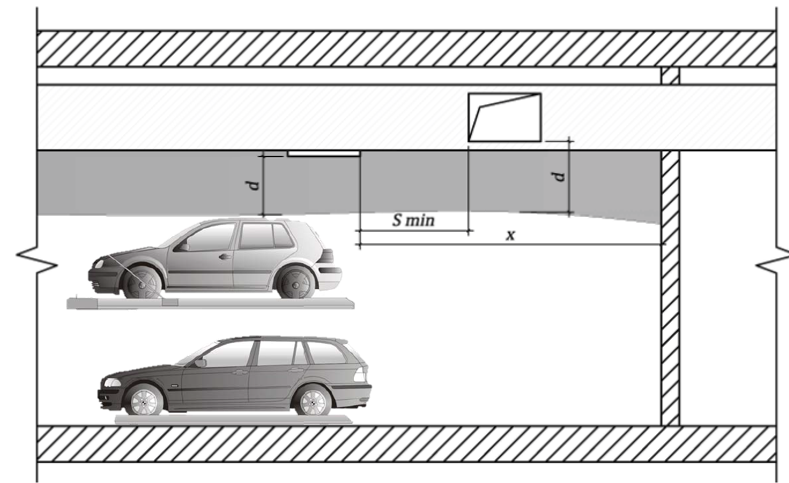

In [1]:
import math
from typing import Literal

class CorridorSmokeInlets:
    def __init__(self, 
                 corridor_height_m: float,
                 G_min_kg_s: float,
                 inlet_position: Literal['Horizontal', 'Vertical'] ='Vertical' ,
                 door_height_m: float = 2.2 ,
                 inlet_width_m: float = 0.7,
                 inlet_height_m: float = 0.5,
                 T_sm: float = 437,
                 T_r: float = 293,
                 ):
        
        self.corridor_height_m = corridor_height_m
        self.G_min_kg_s = G_min_kg_s
        self.inlet_width_m = inlet_width_m
        self.inlet_height_m = inlet_height_m
        self.T_sm = T_sm
        self.T_r = T_r
        self.equivalent_D = self.calculate_equivalent_D(inlet_width_m, inlet_height_m)
        self.smoke_height_m = self.calculate_smoke_height_m(corridor_height_m)
        self.d = round(corridor_height_m - inlet_height_m - 0.05 - self.smoke_height_m , 3)
        self.V_flow_to_one_inlet_max_m3_s = self.calculate_V_max(d=self.d, 
                                                                 T_sm=T_sm,
                                                                 T_r=T_r,
                                                                 inlet_position = inlet_position                                                           
                                                                 )
        self.is_d_enough = self.d > 2*self.equivalent_D
        self.inlet_count_min = self.calculate_N_min(G_min_kg_s=G_min_kg_s,
                                                    T_sm=T_sm,
                                                    V_max_m3_s=self.V_flow_to_one_inlet_max_m3_s
                                               )
        self.L_min = self.calculate_L_min(self.V_flow_to_one_inlet_max_m3_s)
        self.is_inlet_higher_then_door = door_height_m < round(corridor_height_m-0.05-inlet_height_m, 3)

    @classmethod
    def calculate_equivalent_D(cls, A_m: float, B_m: float) -> float:
        """Рассчитывает эквивалентный диаметр дымоприемного устройства"""
        return round((2 * A_m * B_m) / (A_m + B_m), 3)

    @classmethod
    def calculate_smoke_height_m(cls, corridor_height_m: float) -> float:
        """
        3.2.1 - Предельная толщина дымового слоя: 
        0.5 > hsm/corridor_height_m < 0.6
        """
        return round(corridor_height_m * 0.55, 3)

    def calculate_V_max(self, 
                        d: float, 
                        T_sm: float, 
                        T_r: float, 
                        inlet_position: Literal['Horizontal', 'Vertical']) -> float:
        """
        Рассчитывает максимальный расход продуктов горения V_max_m3_s.
        
        Параметры:
        d (float): расстояние от нижней границы дымового слоя до нижней точки дымоприемного устройства (м).
        T_sm (float): средняя температура дымового слоя (К).
        T_r (float): средняя температура воздуха в помещении (К).
        inlet_position (Literal): положение дымоприемного устройства ('Horizontal' или 'Vertical').
        
        Возвращает:
        float: максимальный расход продуктов горения (м³/с).
        """
        if inlet_position == 'Vertical': 
            gamma = 0.5
        else:
            gamma = 1.0
        
        if (T_sm - T_r) < 0:
            raise ValueError("Температура дымового слоя должна быть больше температуры воздуха.")
        
        return 4.16 * gamma * d**(5/2) * ((T_sm - T_r) / T_r)**(1/2)

    def calculate_N_min(self, 
                       G_min_kg_s: float, 
                       T_sm: float, 
                       V_max_m3_s: float) -> int:
        """
        Рассчитывает минимальное количество дымоприемных устройств N_min.
        
        Параметры:
        G_min_kg_s (float): массовый расход продуктов горения (кг/с).
        T_sm (float): плотность продуктов горения (кг/м³).
        V_max_m3_s (float): максимальный расход продуктов горения (м³/с).
        
        Возвращает:
        int: минимальное количество дымоприемных устройств.
        """
        return math.ceil(G_min_kg_s / (353/T_sm) / V_max_m3_s)  

    def calculate_L_min(self, V_max_m3_s: float) -> float:
        """
        Рассчитывает минимальное расстояние между дымоприемными устройствами L_min.
        
        Параметры:
        V_max_m3_s (float): максимальный расход продуктов горения (м³/с).
        
        Возвращает:
        float: минимальное расстояние между устройствами (м).
        """
        return 0.9 * V_max_m3_s**(1/2)
    
    def print_report(self):
        max_label_length = max(
            len("Расстояние между дымоприемными устройствами мин, м"),  
            len("Параметры системы дымоудаления:")
        )
        
        report = (
            f"{'Параметры системы дымоудаления':<{max_label_length}}\n"
            f"{'-' * max_label_length}\n\n"
        )
        
        parameters = [
            ("Высота коридора (м)", self.corridor_height_m, "6.2f"),
            ("Отметка низа дымоприемного (м)", self.corridor_height_m - self.inlet_height_m - 0.05, "6.2f"),
            ("Отметка дымового слоя (м)", self.smoke_height_m, "6.3f"),
            ("Расстояние до слоя (м)", self.d, "6.3f"),
            ("Эквивалентный диаметр (м)", self.equivalent_D, "6.3f"),
            ("Выполнено ли условие по высоте?", self.is_d_enough, ""),
            ("Выполнено ли условие по высоте выше двери?", self.is_inlet_higher_then_door, ""),
            ("Расход продуктов горения (кг/с)", self.G_min_kg_s, "6.3f"),
            ("Высота дымоприемного устройства (м)", self.inlet_height_m, "6.2f"),
            ("Ширина дымоприемного устройства (м)", self.inlet_width_m, "6.2f"),
            ("Температура дыма (К)", self.T_sm, "6.0f"),
            ("Температура воздуха (К)", self.T_r, "6.0f"),
            ("Макс. расход на дымоприемное устройство (м³/с)", self.V_flow_to_one_inlet_max_m3_s, "6.3f"),
            ("Макс. расход на дымоприемное устройство (м³/ч)", self.V_flow_to_one_inlet_max_m3_s*3600, "6.0f"),
            ("Количество дымоприемных устройств, шт", self.inlet_count_min, "6.1f"),
            ("Расстояние между дымоприемными устройствами мин, м", self.L_min, "6.1f"),
        ]
        
        for label, value, fmt in parameters:
            report += f"{label:<{max_label_length}} {value:{fmt}}\n"
        
        print(report)



In [11]:
coridor_1 = CorridorSmokeInlets(
                corridor_height_m=3.0,
                G_min_kg_s=3.6,
                inlet_position="Vertical",
                inlet_height_m=0.4,
                inlet_width_m=0.5, 
                T_sm=437, 
            )

coridor_1.print_report()


Параметры системы дымоудаления                    
--------------------------------------------------

Высота коридора (м)                                  3.00
Отметка низа дымоприемного (м)                       2.55
Отметка дымового слоя (м)                           1.650
Расстояние до слоя (м)                              0.900
Эквивалентный диаметр (м)                           0.444
Выполнено ли условие по высоте?                    True
Выполнено ли условие по высоте выше двери?         True
Расход продуктов горения (кг/с)                     3.600
Высота дымоприемного устройства (м)                  0.40
Ширина дымоприемного устройства (м)                  0.50
Температура дыма (К)                                  437
Температура воздуха (К)                               293
Макс. расход на дымоприемное устройство (м³/с)      1.121
Макс. расход на дымоприемное устройство (м³/ч)       4034
Количество дымоприемных устройств, шт                 4.0
Расстояние между дымоприемными 